# Curso 'Modelado y aprendizaje no supervisado'
## Trabajo Práctico Final

Luego de un extenso recorrido hemos llegado al TP Final del último curso! Felicitaciones por haber llegado al último escalón de esta serie! Solo queda un paso más...

En este TP el objetivo será realizar un agrupamiento de los clientes de una empresa para entender mejor las distintas características que tienen y establecer estrategias de marketing personalizadas (Segmentación de clientes). Por lo que el objetivo principal es generar un análisis de clustering y poder realizar una descripción de las principales características que presentan los clientes que pertenecen a cada cluster.

El dataset que vamos a utilizar es marketing_campaign.csv. En el siguiente [enlace](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) pueden encontrar detallada la información de cada uno de los atributos que conforman este dataset.

El trabajo consistirá en tres secciones:


1.   Preprocesado de los datos: verificar la calidad de los datos, seleccionar las variables de interés, estandarizar los datos.
2.   Reducción de dimensionalidad: realizar un análisis de PCA sobre los datos, determinando el número de componentes principales óptimo según un criterio previamente establecido por el/la estudiante. Realizar un gráfico de puntos de los primeros componentes principales.
3.   Clustering: Realizar k-means a partir del resultado del PCA (es decir, no lo hagan sobre los datos originales!) considerando el valor óptimo de k.
Llevar a cabo un análisis de clustering con otro método según corresponda (ver más abajo). Realizar distintas medidas de validación interna y externa.



Importar paquetes

In [1]:
!pip install kneed

In [2]:
#Librerias generales
import numpy as np
import pandas as pd
from random import sample
from numpy.random import uniform
%matplotlib inline

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Otros
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import silhouette_visualizer
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")


Importar el dataset

In [3]:
df = pd.read_csv('/content/marketing_campaign.csv',delimiter="\t")

In [4]:
df.shape

(2240, 29)

In [5]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# ZONA PREPROCESADO
Aquí tendrá que:


*   Exploración de los datos.
*   Chequear la calidad de los datos (esto incluye detectar si existen outliers y, en caso de que los hubiere, decidir qué hacer con ellos).
*   Seleccionar los atributos de interés: para los siguientes pasos solo nos van a interesar las **variables numéricas**! OJO que en el dataset existen variables que son solo dicotómicas (tomar valores 0 ó 1), esas variables no deben ser tenidas en cuenta para los siguientes pasos. Guarde las variables categóricas en una tabla separada ya que luego serán tenidas en cuenta para realizar validaciones externas.
*   Con la variable **Year_Birth** podría establecer la edad de los clientes, considerando que la edad aproximada será 2023 - **Year_Birth**.
*   Estandarizar los datos.




### EDA:

Tenemos un dataset de 29 columnas y 2240 registros:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [7]:
df.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


En busca de datos nulos:

In [8]:
def isna(df):
  if df.isna().sum().any():
    columnas_nulos = df.columns[df.isna().sum() > 0]
    print(f'columna con datos nulos:{columnas_nulos}')
  else:
    print('No se encontraron datos nulos')

isna(df)

columna con datos nulos:Index(['Income'], dtype='object')


In [9]:
df['Income'].isna().sum()

24

Vemos que la columna "Income" contiene 24 datos nulos sobre un total de 2240 registros. Exploremos esta variable:

In [10]:
df['Income'].value_counts()

7500.0     12
35860.0     4
37760.0     3
83844.0     3
63841.0     3
           ..
40760.0     1
41452.0     1
6835.0      1
33622.0     1
52869.0     1
Name: Income, Length: 1974, dtype: int64

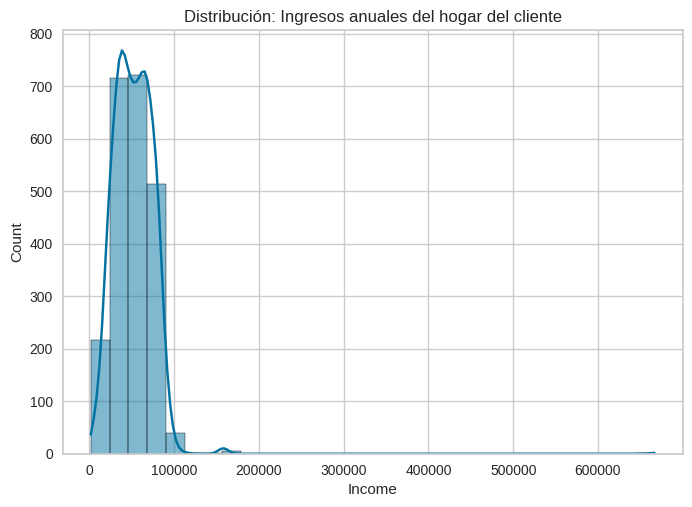

In [11]:
sns.histplot(data = df, x = 'Income', bins = 30, kde = True)
plt.title("Distribución: Ingresos anuales del hogar del cliente")
plt.show()

Notamos en esta variable que, además de tener datos nulos, contiene algunos outliers, es decir, la mayoria de los clientes gana entre 0 y 10.000 (¿dolares?) y  hay un pequeño grupo que gana por encima de 60.000.

Veamos el box-plot de esta variable para ahondar en ella:

<Axes: ylabel='Income'>

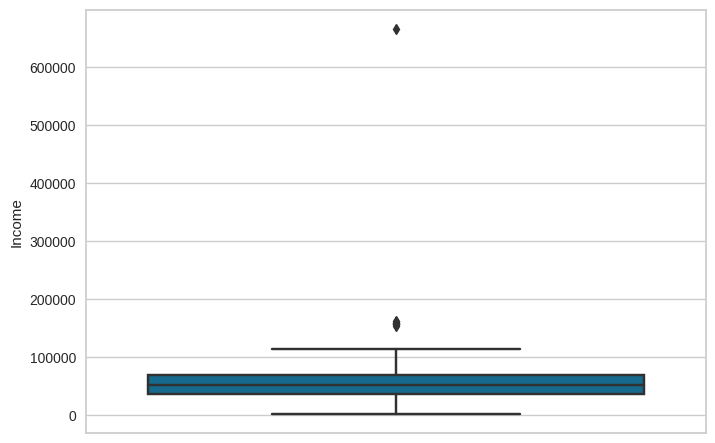

In [12]:
sns.boxplot(data= df, y="Income")

In [13]:
#veamos la variable ordenada desde el que más gana hasta el que menos:
Ingresos = df['Income'].sort_values(ascending=False)
Ingresos.head(5)

2233    666666.0
617     162397.0
687     160803.0
1300    157733.0
164     157243.0
Name: Income, dtype: float64

Como vemos hay un sólo registro que contiene un outlier, por lo tanto, considero que es mejor eliminarlo. Se podría argumentar en contra de esta decisión que existen clientes de un minoritario subgrupo de la sociedad que tienen ese poder adquisitivo y si hubiese más registros con valores similares creo que se debería considerar mantenerlos. Pero no es el caso, por lo cual concluyo que es un dato que debe ser descartado.

In [14]:
#eliminamos el outlier:
df=  df.drop(2233)

Chequeamos que se haya eliminado correctamente:

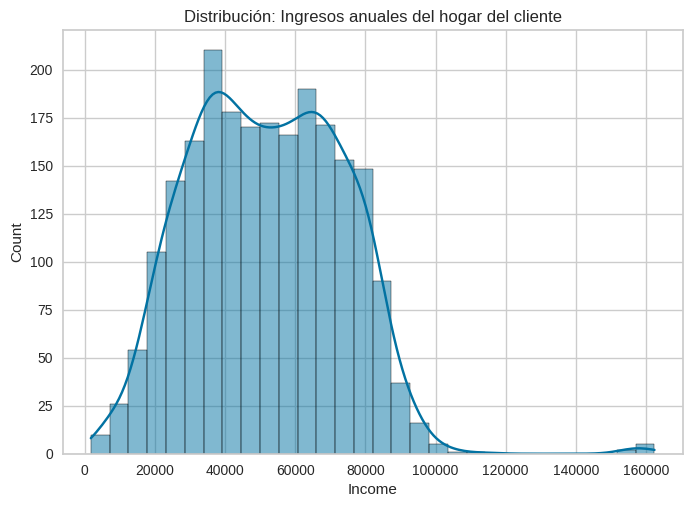

In [15]:
sns.histplot(data = df, x = 'Income', bins = 30, kde = True)
plt.title("Distribución: Ingresos anuales del hogar del cliente")
plt.show()

En el histograma ahora si podemos intuir un subgrupo de clientes que ganan muy por encima de la media. Este subgrupo lo podemos considerar como potencialmente representativo de la sociedad, por lo tanto, sería valioso mantenerlo.

Ahora podemos imputar los datos faltantes con el valor promedio de los ingresos de los clientes.

In [16]:
Promedio_ingresos = (df['Income'].mean())
df['Income'] = df['Income'].fillna(Promedio_ingresos)

In [17]:
isna(df)

No se encontraron datos nulos


### Variable "Age"

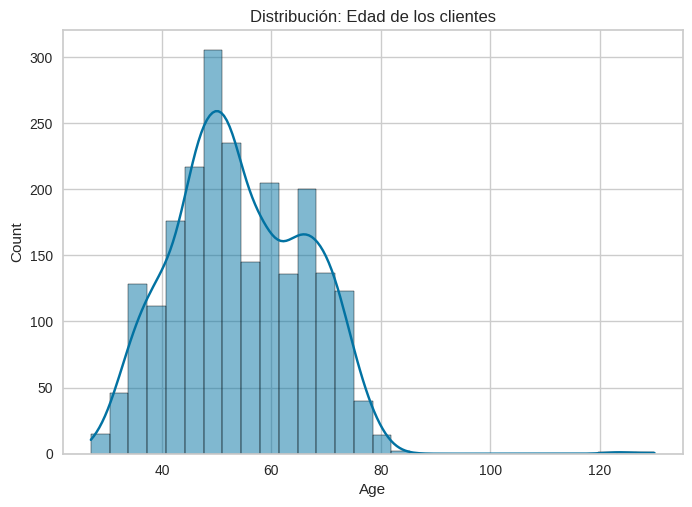

In [18]:
#creamos la variable edad restando a 2023 el año de nacimiento
Año_de_nacimiento = df['Year_Birth']
df['Age'] = 2023 - Año_de_nacimiento
#graficamos el resultado:
sns.histplot(data = df, x = 'Age', bins = 30, kde = True)
plt.title("Distribución: Edad de los clientes")
plt.show()

In [19]:
#chequeamos si hay algun error:
matusalen = df['Age'].values > 90
df[matusalen]

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
192,7829,1900,2n Cycle,Divorced,36640.0,1,0,26-09-2013,99,15,...,0,0,0,0,0,1,3,11,0,123
239,11004,1893,2n Cycle,Single,60182.0,0,1,17-05-2014,23,8,...,0,0,0,0,0,0,3,11,0,130
339,1150,1899,PhD,Together,83532.0,0,0,26-09-2013,36,755,...,0,0,1,0,0,0,3,11,0,124


Encontramos 3 clientes con edades entre 120 y 130 años que, podemos intuir, ya han fallecido. Los eliminaremos ya que estamos utilizando datos de clientes actuales.

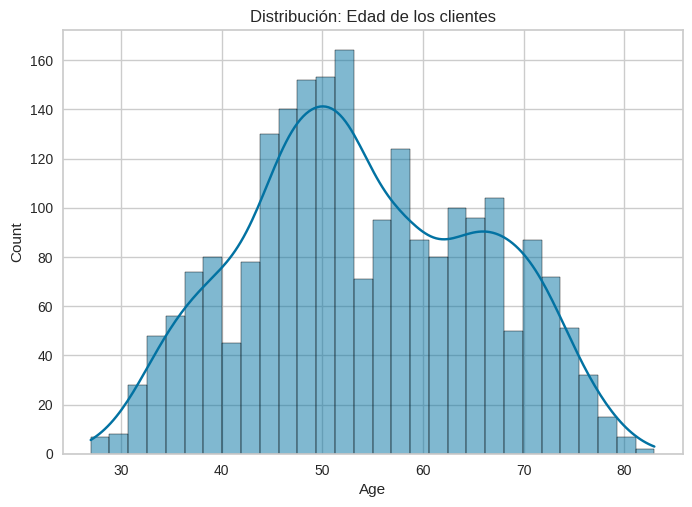

In [20]:
filas_a_eliminar = [192, 239, 339]
df = df.drop(filas_a_eliminar)
df['Age'] = 2023 - Año_de_nacimiento
sns.histplot(data = df, x = 'Age', bins = 30, kde = True)
plt.title("Distribución: Edad de los clientes")
plt.show()

### Otras variables

Grafiquemos los datos de algunas variables que podrían ser informativas:

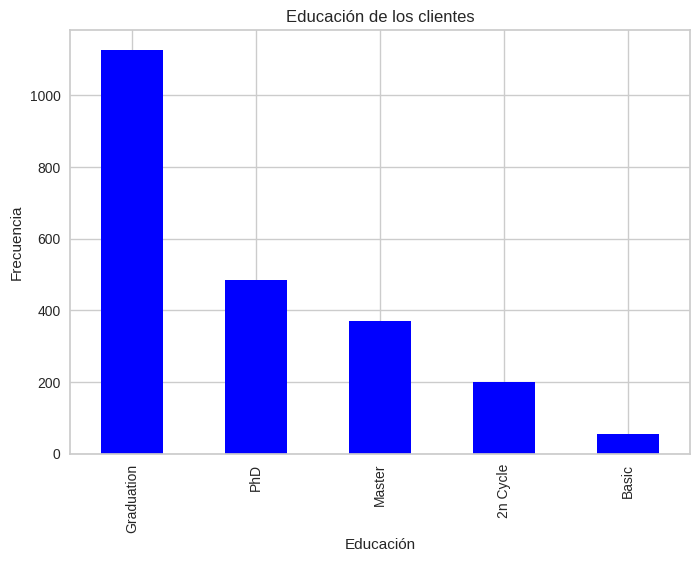

In [21]:
ax = df['Education'].value_counts() \
     .plot(kind='bar', title='Educación de los clientes', color= 'blue')
ax.set_xlabel('Educación')
ax.set_ylabel('Frecuencia')
plt.show()

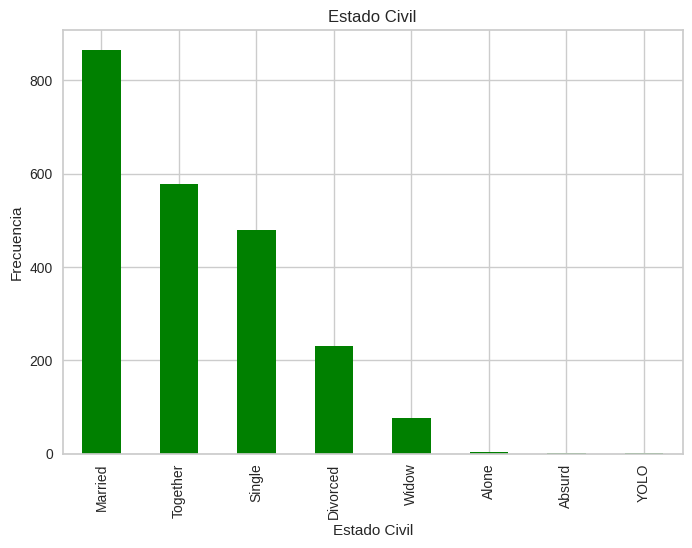

In [22]:
ax = df['Marital_Status'].value_counts() \
     .plot(kind='bar', title='Estado Civil', color= 'green')
ax.set_xlabel('Estado Civil')
ax.set_ylabel('Frecuencia')
plt.show()

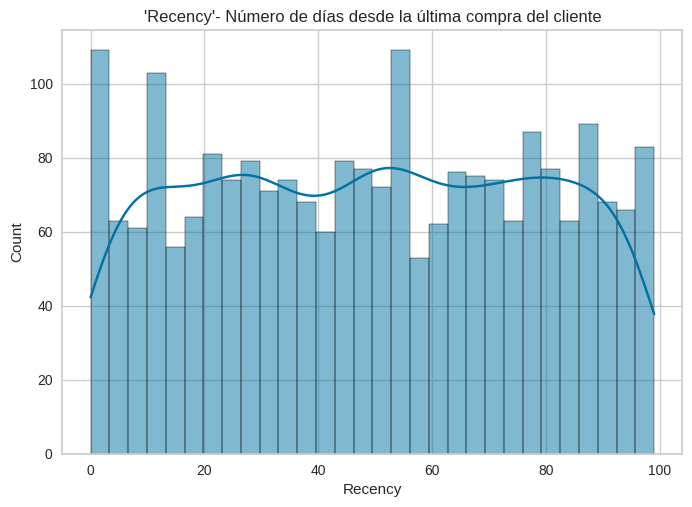

In [23]:
sns.histplot(data = df, x = 'Recency', kde = True, bins=30)
plt.title("'Recency'- Número de días desde la última compra del cliente")
plt.show()

Tomamos las columnas de gastos en cada categoría y sacaremos el porcentaje sobre los gastos totales de todos los clientes. De esta manera podremos saber que categoría es en la que se gasta más dinero.

In [24]:
columnas = df[['MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntGoldProds','MntSweetProducts']]

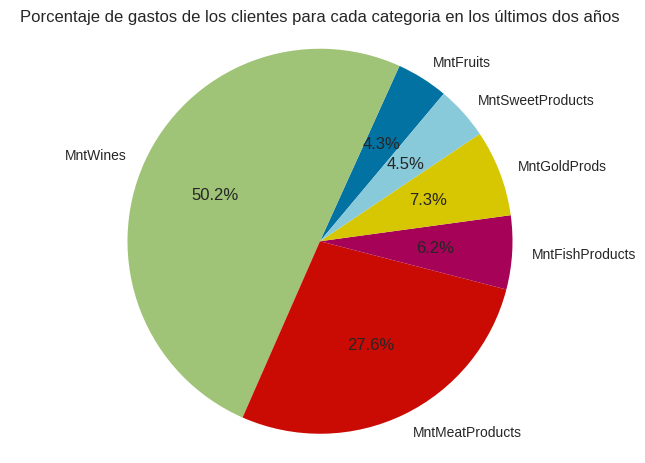

In [25]:
suma_columnas = columnas.sum()
total = columnas.sum().sum()
porcentajes = (suma_columnas/total)*100

porcentajes.plot(kind='pie', autopct='%1.1f%%', startangle=50)
plt.title('Porcentaje de gastos de los clientes para cada categoria en los últimos dos años')
plt.axis('equal')
plt.show()

Observemos la sección "Place" , donde se detalla a través de qué medios se realizaron las compras:

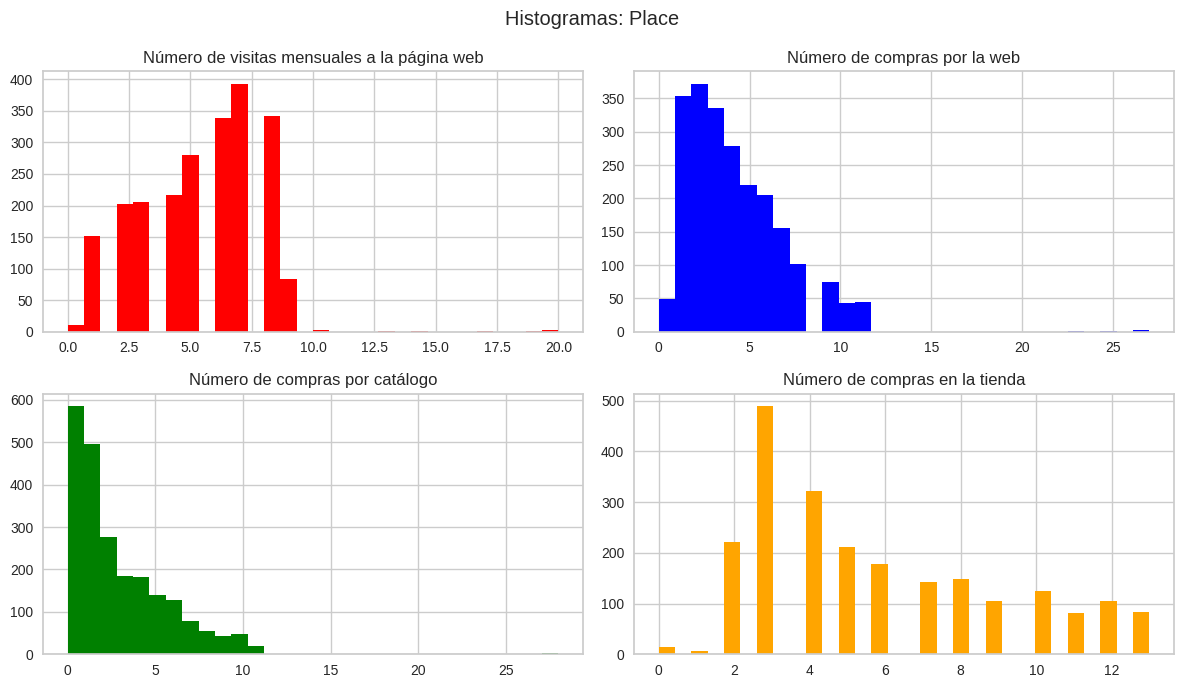

In [26]:

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

axs[0, 0].hist(df['NumWebVisitsMonth'],color='red', bins=30)
axs[0, 1].hist(df['NumWebPurchases'],color='blue', bins=30)
axs[1, 0].hist(df['NumCatalogPurchases'],color='green', bins=30)
axs[1, 1].hist(df['NumStorePurchases'],color='orange', bins=30)


axs[0, 0].set_title('Número de visitas mensuales a la página web')
axs[0, 1].set_title('Número de compras por la web')
axs[1, 0].set_title('Número de compras por catálogo')
axs[1, 1].set_title('Número de compras en la tienda')

plt.suptitle('Histogramas: Place')
plt.tight_layout()
plt.show()


### Un poco de featuring engineering:

In [27]:
#creamos la columna "Hijos" que suma las columnas 'kid' y 'teen':
df['Hijos'] = df['Kidhome']+ df['Teenhome']

#creamos la columna 'Total Compras', que suma el gasto en todas las categorías en los últimos dos años:
df['Total_compras'] = df['MntFruits'] + df['MntWines'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntGoldProds'] + df['MntSweetProducts']

#creamos la variable porcentaje de gastos en la tienda sobre el ingreso anual:
df['%gastos/income'] = ((df['Total_compras']/2)*100)/df['Income'] #dividimos Total compras por 2 para tener el
# gasto anual y poder sacar el porcentaje sobre los ingresos anuales


Grafiquemos las variables creadas:

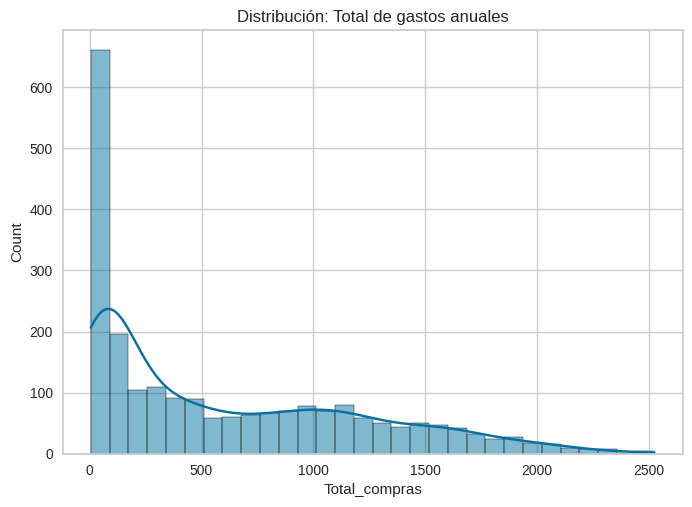

In [28]:
sns.histplot(data = df, x = 'Total_compras', kde = True, bins=30)
plt.title("Distribución: Total de gastos anuales")
plt.show()

Podemos apreciar que la mayoría de los clientes gasta alrededor de 600 (dolares?) anuales en el total de los productos de la tienda.

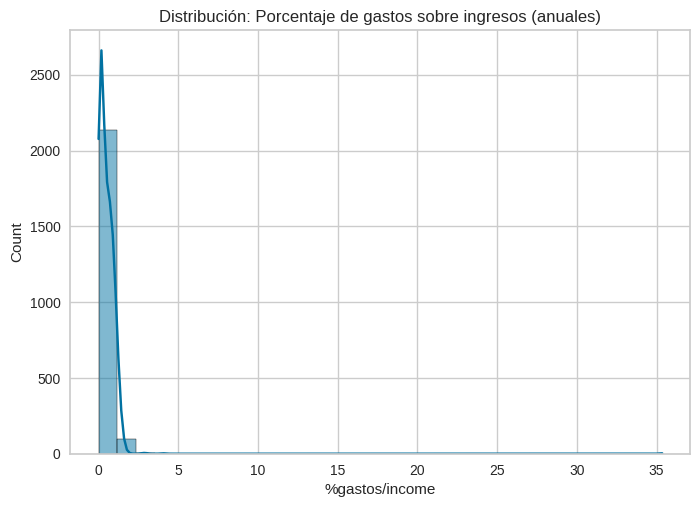

In [29]:
sns.histplot(data = df, x = '%gastos/income', kde = True, bins=30)
plt.title("Distribución: Porcentaje de gastos sobre ingresos (anuales)")
plt.show()

Vemos que la gran mayoría de los clientes gasta menos del 5% de su ingreso anual en productos de la compañia.

### Ahora seleccionaremos las columnas de interés:

In [30]:
#contamos cuantos valores únicos tiene cada columna:
for column in df.columns:
    unique_values = df[column].nunique()
    print(f"{column}: {unique_values}")

ID: 2236
Year_Birth: 56
Education: 5
Marital_Status: 8
Income: 1971
Kidhome: 3
Teenhome: 3
Dt_Customer: 663
Recency: 100
MntWines: 775
MntFruits: 158
MntMeatProducts: 557
MntFishProducts: 182
MntSweetProducts: 177
MntGoldProds: 213
NumDealsPurchases: 15
NumWebPurchases: 15
NumCatalogPurchases: 14
NumStorePurchases: 14
NumWebVisitsMonth: 16
AcceptedCmp3: 2
AcceptedCmp4: 2
AcceptedCmp5: 2
AcceptedCmp1: 2
AcceptedCmp2: 2
Complain: 2
Z_CostContact: 1
Z_Revenue: 1
Response: 2
Age: 56
Hijos: 4
Total_compras: 1054
%gastos/income: 2030


De ahora en más dejaremos el df original y trabajaremos con el df1, donde realizaremos los siguientes cambios:

In [31]:
#eliminamos las columnas como Id -que al ser una secuencia de números o caracteres que no se repiten, no aporta datos relevantes-
# o las colummnas que contienen un solo valor único
df1 = df.drop(columns = ['ID', 'Z_CostContact', 'Z_Revenue'])

#excluimos a las variables de tipo object, incluida la columna "date"
col_num = df1.select_dtypes(exclude=['object'])
df1 = col_num

#excluimos las variables númericas categóricas:
df_cat_col = df1[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'Complain','Response']]
df1 = df1.drop(columns = df_cat_col)

In [32]:
df1

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Hijos,Total_compras,%gastos/income
0,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,66,0,1617,1.390657
1,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,69,2,27,0.029130
2,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,58,0,776,0.541801
3,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,39,1,53,0.099452
4,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,42,1,422,0.361965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,56,1,1341,1.095177
2236,1946,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,77,3,444,0.346799
2237,1981,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,42,0,1241,1.088959
2238,1956,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,67,1,843,0.608708


## Relación entre variables:

Exploremos la relación entre los ingresos anuales de un clientes y el total de gastos en la tienda en los últimos dos años:

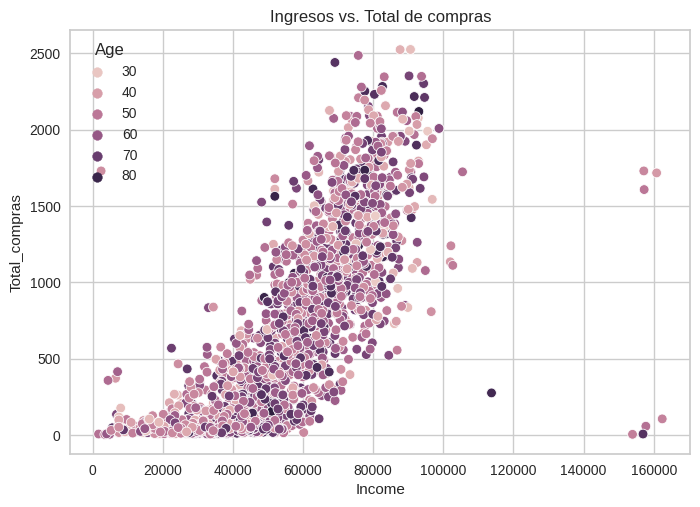

In [33]:

ax = sns.scatterplot(x='Income',
                y='Total_compras',
                hue='Age',
                data=df1)
ax.set_title('Ingresos vs. Total de compras')
plt.show()

Podemos apreciar una tendencia lineal en la relación: en la medida que se tienen más ingresos suele corresponderse con un mayor gasto en la tienda.

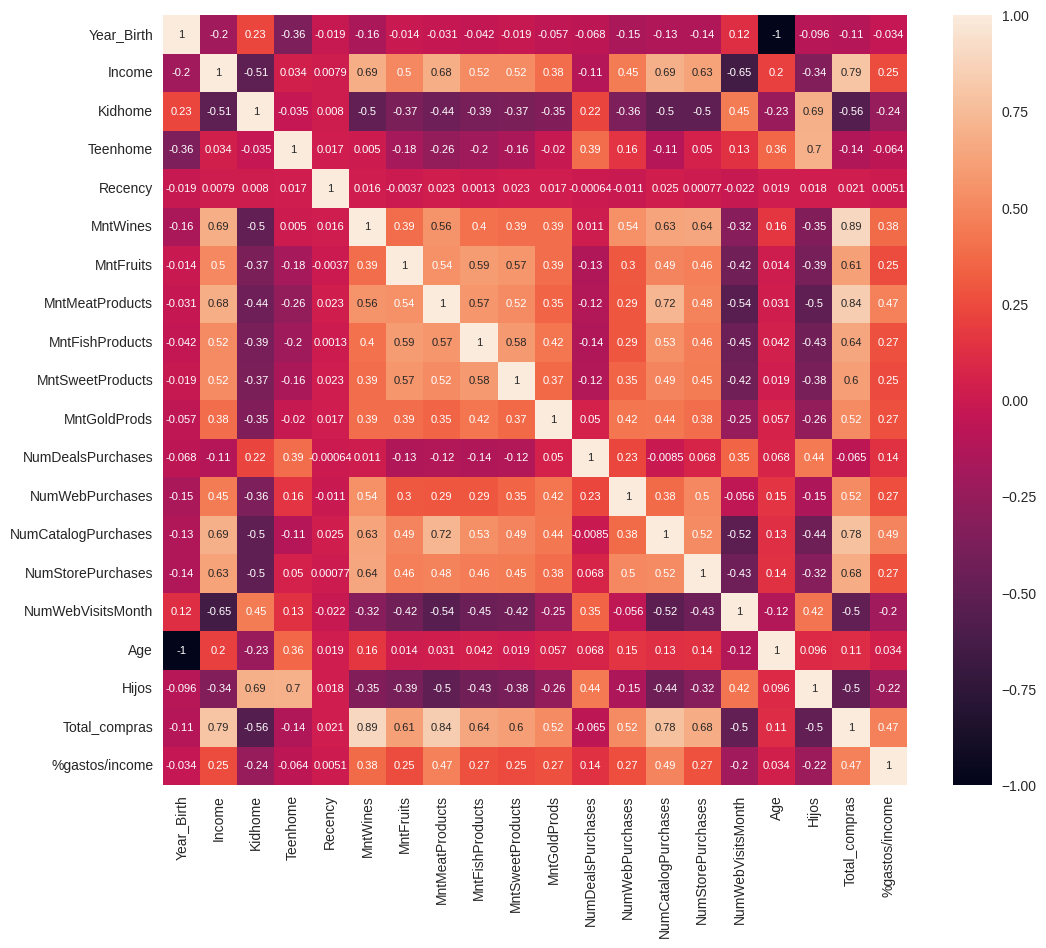

In [34]:
#sacamos las correlaciones
df_corr = df1.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True,annot_kws={"size": 8})
plt.show()

Como Year_Birth y edad son dos variables están completamente correlacionadas (en este caso negativamente) aparecen con -1.
También encontramos una fuerte correlación entre el gasto en productos de vino y productos de carne con la variable creada "Total_Compras", esto se debe a que estas variables son las que más pesan sobre el total de los gastos a la hora de sumar cada categría.

## Escalamos los datos:

In [35]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df1)
df_scaled = pd.DataFrame(scaled, columns = df1.columns)
df_scaled.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Hijos,Total_compras,%gastos/income
0,-1.016868,0.288653,-0.824939,-0.930615,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,0.348738,1.407639,2.509801,-0.552429,0.692865,1.016868,-1.264308,1.680176,1.067755
1,-1.273264,-0.262299,1.032627,0.905974,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,-0.168700,-1.110921,-0.568970,-1.167738,-0.131421,1.273264,1.395139,-0.962202,-0.556556
2,-0.333146,0.918132,-0.824939,-0.930615,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,-0.686137,1.407639,-0.226884,1.293496,-0.543564,0.333146,-1.264308,0.282541,0.055064
3,1.290693,-1.182483,1.032627,-0.930615,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,-0.168700,-0.751127,-0.911056,-0.552429,0.280722,-1.290693,0.065416,-0.918994,-0.472661
4,1.034298,0.295893,1.032627,-0.930615,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,1.383614,0.328256,0.115201,0.062879,-0.131421,-1.034298,0.065416,-0.305762,-0.159482


# ZONA REDUCCIÓN DE LA DIMENSIONALIDAD

Aquí tendrá que:


*   Llevar a cabo un PCA con las variables númericas ya estandarizadas del dataset
*   Determinar el número de componentes principales que serán tenidos en cuenta para los siguientes análisis de este Trabajo Práctico.
*   Graficar la distribución de los clientes (observaciones) en los dos primeros componentes principales.
*   ¿Cuáles son las variables originales más importantes en estos primeros componentes principales?


### Covarianza:

Realizamos la matriz de covarianza:


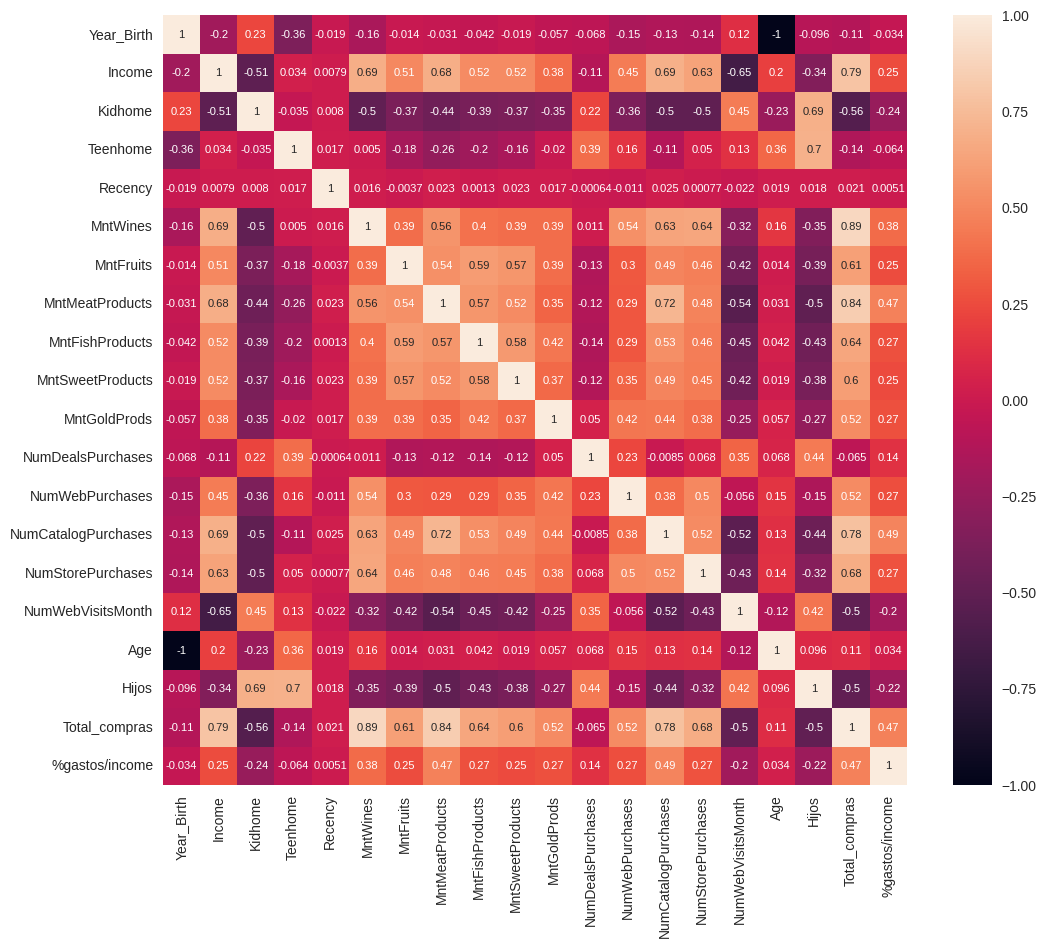

In [36]:
#Covarianza
cov = df_scaled.cov()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cov, annot=True,annot_kws={"size": 8})
plt.show()

## Realizamos la reducción de la dimensionalidad con PCA:

In [37]:
# PCA
pca = PCA()
df_PCA = pca.fit_transform(df_scaled)

# Convertimos el resultado en un dataframe
component_names = [f"PC{i+1}" for i in range(df_PCA.shape[1])]
df_PCA = pd.DataFrame(df_PCA, columns=component_names)

df_PCA.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,4.521075,0.234782,0.187020,0.147125,0.968869,0.186279,2.610104,-0.965385,-0.043507,0.350695,0.036251,-1.794785,-0.259234,0.541239,-0.696773,0.346000,-0.333060,2.409149e-14,-5.322661e-16,3.576877e-17
1,-2.707821,1.616240,-1.494582,-0.563379,-0.323564,1.261809,0.069523,0.069430,-0.462326,0.235078,0.084289,-0.065959,0.092634,-0.002279,-0.121591,-0.114184,0.056793,6.505496e-16,5.234959e-15,-2.521347e-15
2,2.150093,-0.345661,-0.770197,1.268815,-0.763224,-0.695738,0.078407,-0.605101,0.331570,-0.245294,-0.269796,0.936279,-0.658065,1.229762,-0.068613,-0.207092,0.476347,2.805612e-16,2.603675e-15,-2.436960e-15
3,-2.732030,-2.053492,0.463950,0.518132,-0.352775,0.415306,-0.144291,-0.180532,0.010646,-0.242345,0.041901,0.398701,-0.119319,0.047076,-0.018959,-0.040688,-0.280539,1.613708e-17,1.840366e-15,3.426731e-15
4,-0.434556,-1.007504,1.521346,-1.535289,0.432564,-0.393243,0.067382,-0.799555,0.326353,-1.075526,0.333185,0.288220,0.403049,0.752920,-0.425651,-0.363770,0.303208,-1.834583e-17,-1.946129e-16,-1.954756e-18


Determinamos el número de componentes principales que utilizaremos a partir de observar el gráfico de varianza acumulada:

In [38]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Componente", title="% Varianza Explicada", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Componente", title="% Varianza Acumulada", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<Axes: title={'center': '% Varianza Explicada'}, xlabel='Componente'>,
       <Axes: title={'center': '% Varianza Acumulada'}, xlabel='Componente'>],
      dtype=object)

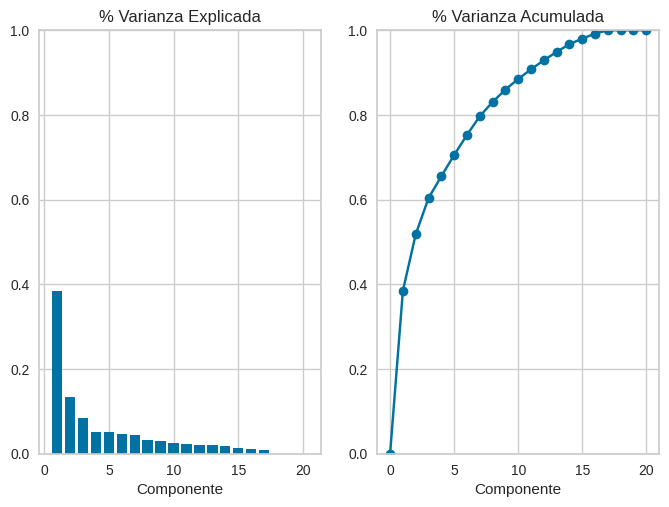

In [39]:
plot_variance(pca)

Podemos observar que el primer pca explica casi el 40% de la varianza de los datos y que el segundo y el tercero rondan alrededor de un 10%.
En el gráfico de varianza acumulada observamos que para obtener el 80% de la varianza de nuestros datos necesitamos al menos 7 componentes principales; vamos a probar con esa cantidad.

In [40]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=df_scaled.columns,
)
loadings_7 = loadings.iloc[:, :7]
loadings_7

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Year_Birth,-0.058097,-0.470825,0.420653,-0.041084,-0.093204,-0.055544,-0.239628
Income,0.299245,0.087960,-0.035364,-0.128749,-0.128144,0.085663,-0.326749
Kidhome,-0.246068,-0.037470,0.225790,-0.281493,-0.045500,0.331565,0.143957
Teenhome,-0.060778,0.483067,0.111659,-0.154884,-0.221856,0.022245,-0.270770
Recency,0.005432,0.017172,-0.010197,-0.724051,0.456937,-0.511006,0.013098
MntWines,0.278745,0.121532,0.130451,0.140562,0.141676,-0.103859,-0.288842
MntFruits,0.248096,-0.087466,0.024498,-0.174451,-0.281682,0.059495,0.288770
MntMeatProducts,0.295062,-0.090461,0.022998,-0.093944,0.176448,0.273467,-0.038663
MntFishProducts,0.257864,-0.087007,-0.002586,-0.166248,-0.227406,0.076199,0.325265
MntSweetProducts,0.246647,-0.073586,0.031961,-0.199483,-0.277553,0.010188,0.263687


Grafiquemos los loadings para poder apreciar de forma visual el peso de cada variable para cada componente principal:

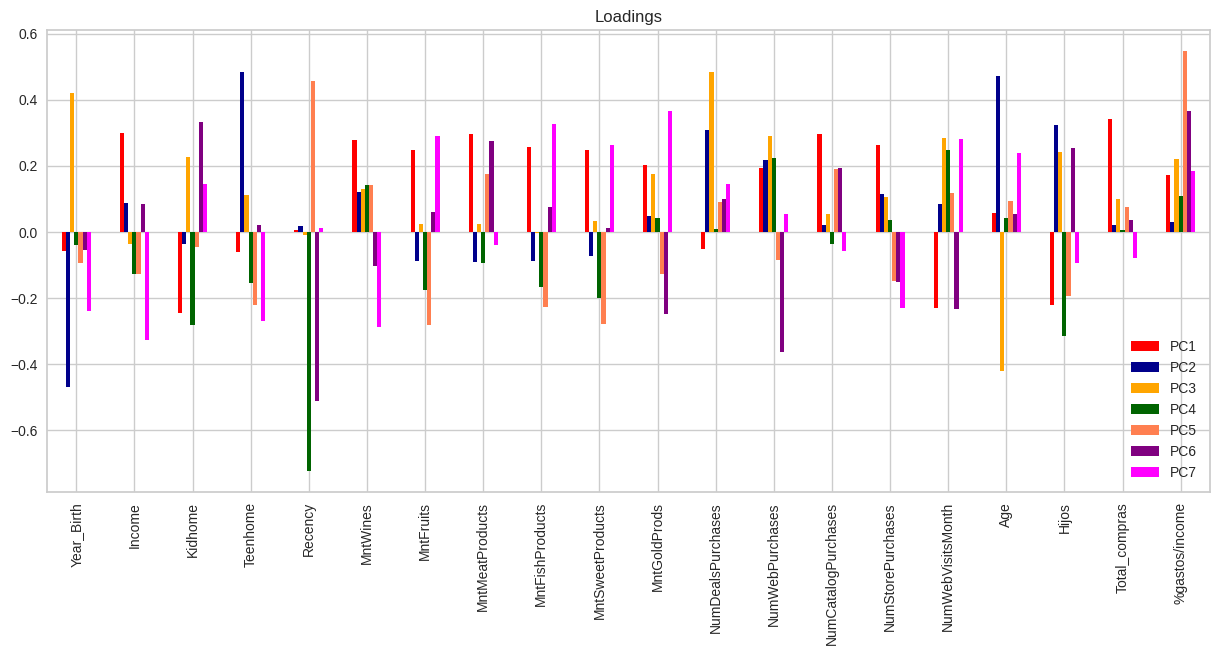

In [41]:
color = ['red','darkblue','orange','darkgreen','coral', 'purple','magenta']
ax = loadings_7 \
    .plot(kind='bar', figsize=(15,6), color=color, title='Loadings')
plt.show()

Nos quedamos con los primeros 7 componentes principales:

In [42]:
df_PCA = df_PCA.drop(columns = ['PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17', 'PC18', 'PC19', 'PC20'])

Graficamos el primer y el segundo componente:

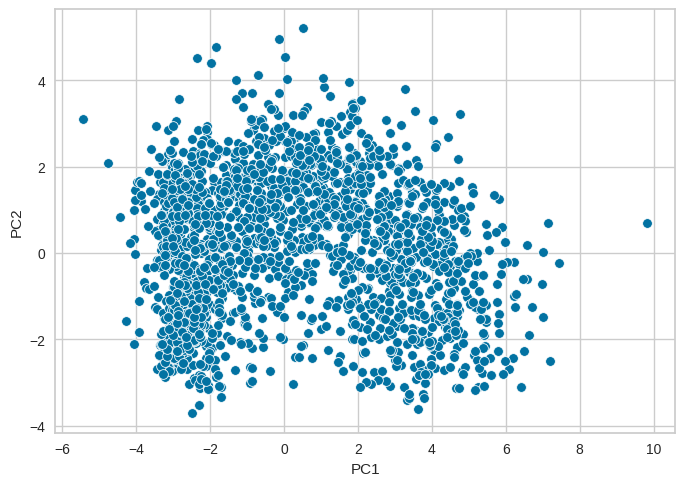

In [43]:
ax = sns.scatterplot(x='PC1',
                y='PC2',
                data=df_PCA)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Focalizemos sobre los primeros 4 componentes pricipales:

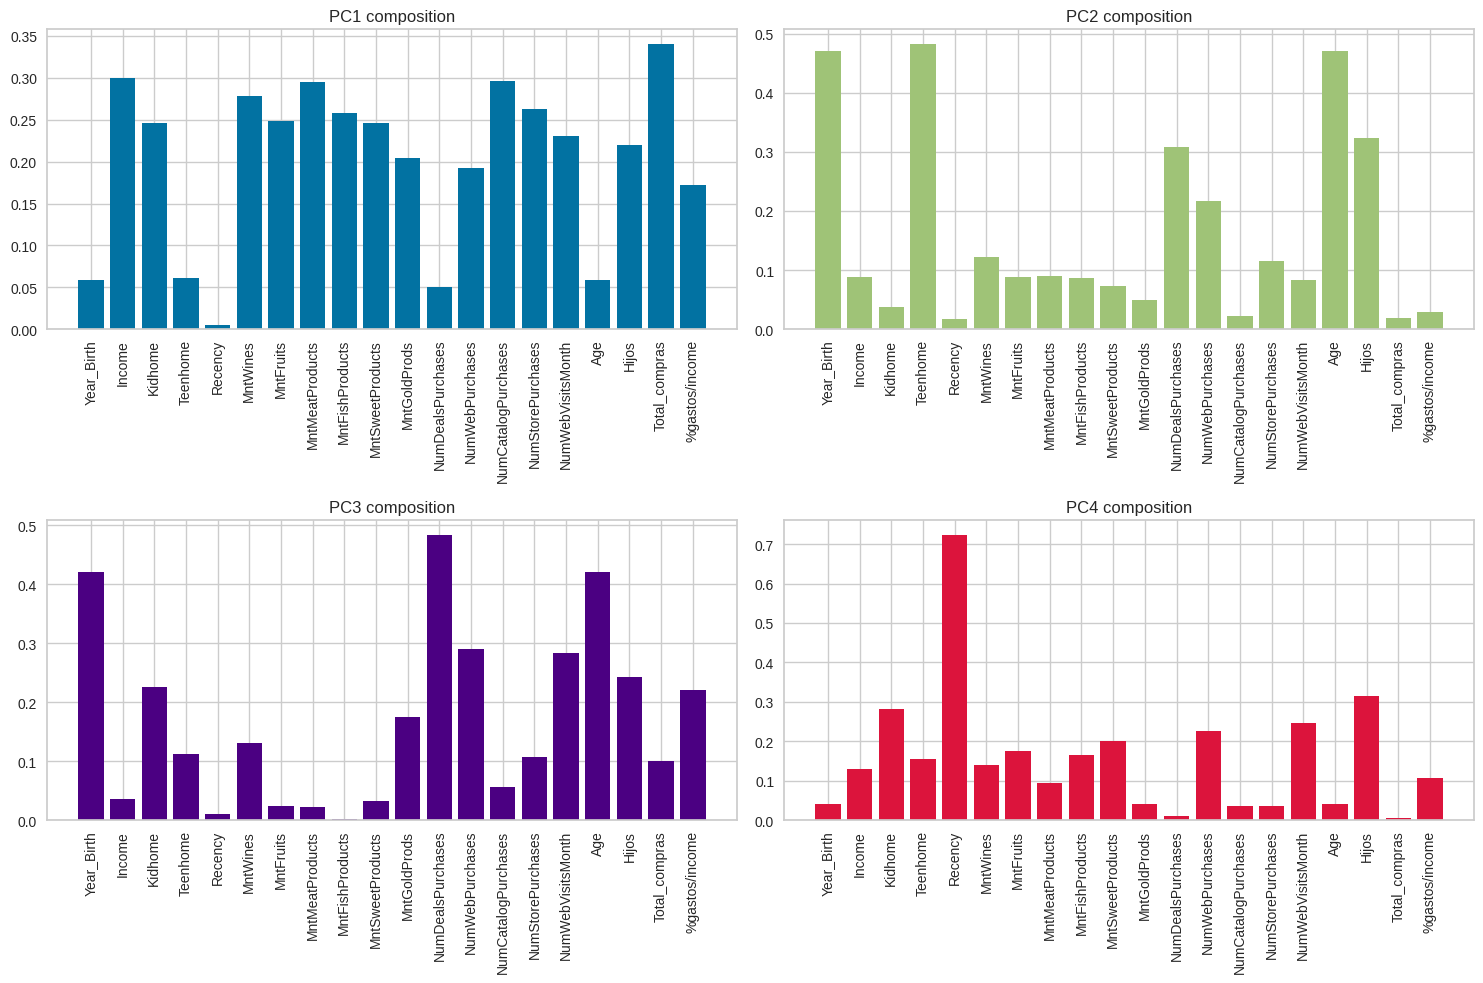

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))


axs[0,0].bar(loadings_7.index, abs(loadings_7['PC1']), color='b')
axs[0,0].set_title('PC1 composition')


axs[0,1].bar(loadings_7.index, abs(loadings_7['PC2']), color='g')
axs[0,1].set_title('PC2 composition')

axs[1,0].bar(loadings_7.index, abs(loadings_7['PC3']), color='indigo')
axs[1,0].set_title('PC3 composition')

axs[1,1].bar(loadings_7.index, abs(loadings_7['PC4']), color='crimson')
axs[1,1].set_title('PC4 composition')


axs[0,0].set_xticklabels(loadings_7.index, rotation=90)
axs[0,1].set_xticklabels(loadings_7.index, rotation=90)
axs[1,0].set_xticklabels(loadings_7.index, rotation=90)
axs[1,1].set_xticklabels(loadings_7.index, rotation=90)
plt.tight_layout()
plt.show()

Las variables originales más importantes son:

PC1: En el primer componente principal observamos que las variables que lo componen participan de una forma más homogénea, que en el resto de los componentes principales. Se descatan las columnas: "Total Compras", "Income", "MntMeatProducts" y "NumCatalogPurchases".

PC2: Este componente muestra un claro anclaje en las variables relacionadas con edad e hijos.

PC3: En este componente podemos apreciar que se destacan además de la edad, la columna "NumDealsPurchases", que hace referencia a la cantidad de compras en oferta de los clientes.

PC4: En este componente principal la variable 'Recency' es la que mejor lo explica; esta colummna hace referencia a la cantidad de dias pasados desde la última compra del cliente.

# ZONA CLUSTERING

Aquí tendrá que:


*   Realizar un análisis de k-means a partir de la reducción de dimensionalidad realizada en el punto anterior. Para ésto tendrá que determinar el k-óptimo.
*   Implementar un segúndo método de clustering sobre los datos. El método dependerá del número de documento del/de la estudiante:

      **  **DNI par (0, 2, ..., 8):** realizar un clustering jerárquico.

      **  **DNI impar (1, 3, ..., 9):** realizar DBScan.

      En cualquiera de los dos casos, deberá establecer los parámetros óptimos para realizar el clustering.
*   Realizar una validación interna del clustering k-means con el k-seleccionado. Comparar el resultado con otro clustering con un k distinto.
*   Realizar una validación externa tomando como "información externa" alguna de las variables categóricas del dataset: Education	o Marital_Status. ¿Están relacionadas con los grupos que se establecen?
*   **ÚLTIMO PUNTO:** Interpretar los clusters que formó! ¿Qué caracteriza a los clientes que pertenecen a un determinado cluster? Tenga en cuenta que como el clustering lo está haciendo sobre el espacio de baja dimensionalidad (PCA) va a tener que pensar muy bien este punto...




## K- means

Iteremos en busca del mejor K para nuestro modelo:

In [45]:

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# SSE: Sum of Square Error
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_PCA)
    sse.append(kmeans.inertia_)

Grafiquemos los valores de la suma de los cuadrados de las distancias para cada valor de k:

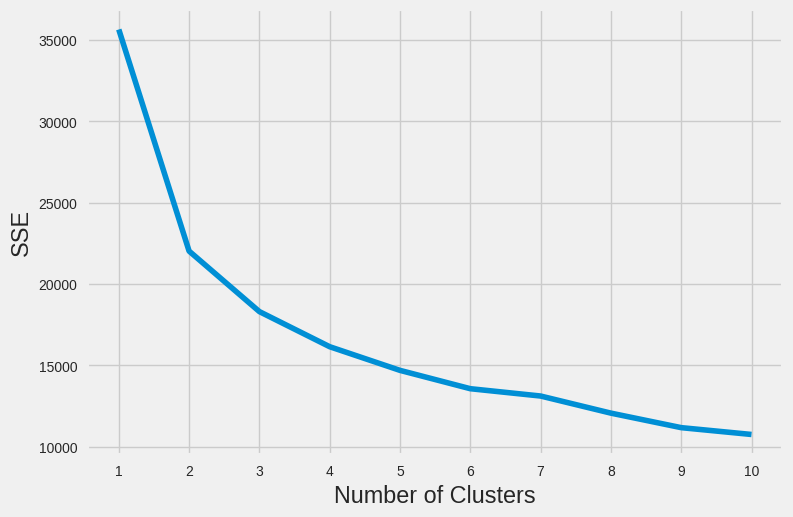

In [46]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [47]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

En nuestran gráfica apreciamos que el 'codo' más pronunciado lo hayamos con el número 2, sin embargo, al utilizar la clase 'KneeLocator' para encontrar automáticamente el 'codo' en la gráfica, nos devuelve 3. Asumamos que el número 3 es el correcto y exploremos sus resultados:

In [48]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(df_PCA)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [49]:
print(f'cluster centers: {kmeans.cluster_centers_}')
print(f'labels: {kmeans.labels_}')

cluster centers: [[ 3.77753847 -0.75469956 -0.23663574 -0.20337685 -0.02952189  0.22059634
   0.10090598]
 [ 0.55005242  1.54697291  0.47251418  0.33656455 -0.04542556 -0.38526579
  -0.26218672]
 [-2.46459477 -0.51298798 -0.15323883 -0.08950572  0.04421669  0.10934432
   0.10217508]]
labels: [0 2 0 ... 0 1 2]


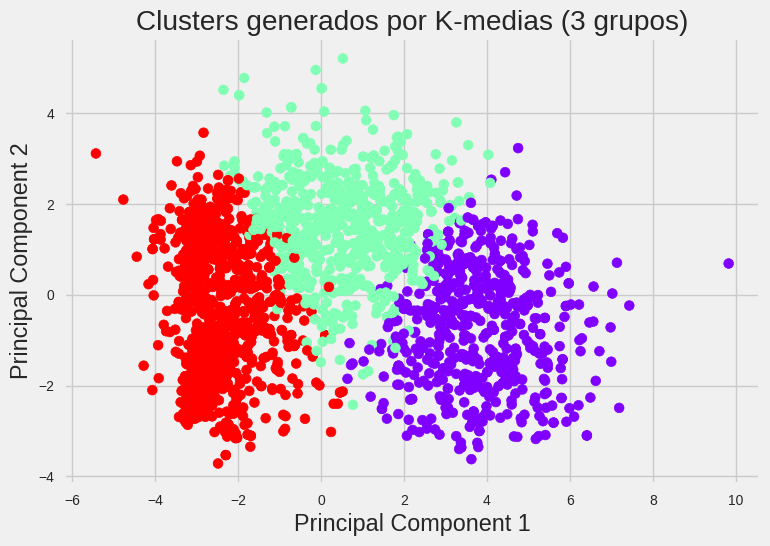

In [50]:
plt.scatter(df_PCA['PC1'], df_PCA['PC2'], c = kmeans.labels_, cmap='rainbow')
plt.title('Clusters generados por K-medias (3 grupos)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Clustering Jerárquico

Compararemos estos resultados con otro método de clustering: el clustering jerárquico. Utilizaremos diversos métodos de linkage para nuestras pruebas y visualizaremos los resultados a través de un dendograma.

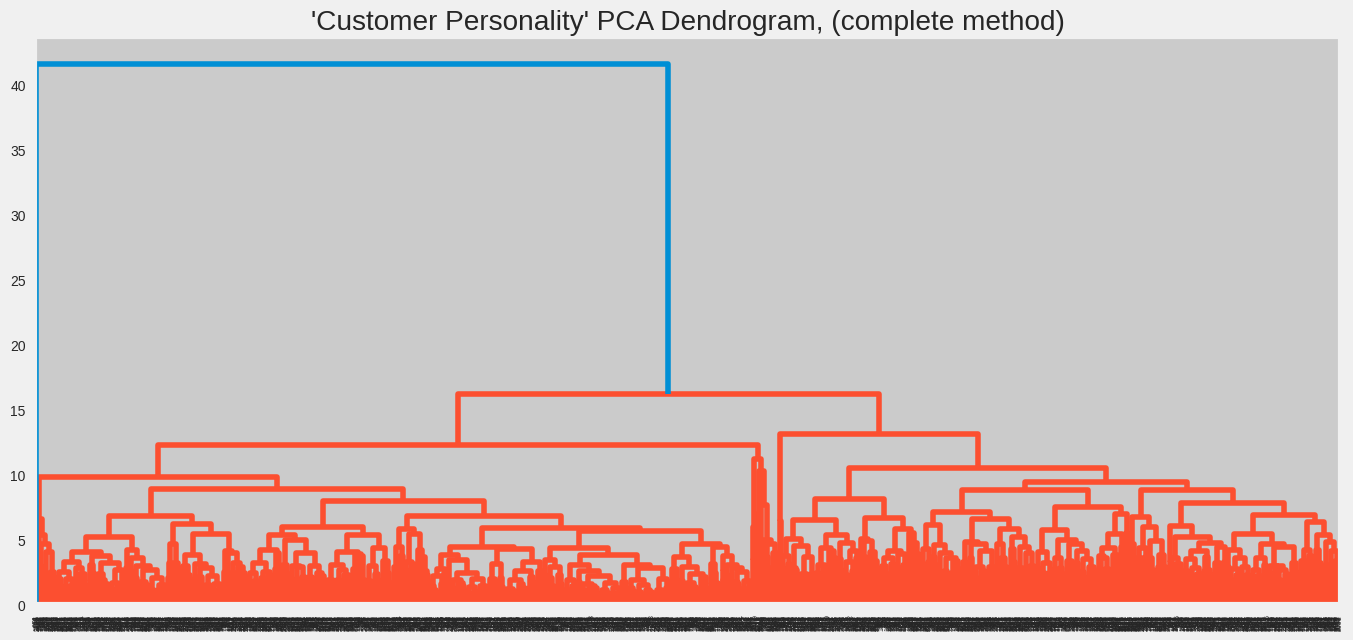

In [51]:
#Complete linkage
plt.figure(figsize=(15, 7))
plt.title("'Customer Personality' PCA Dendrogram, (complete method)")

clusters = shc.linkage(df_PCA,
            method='complete',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

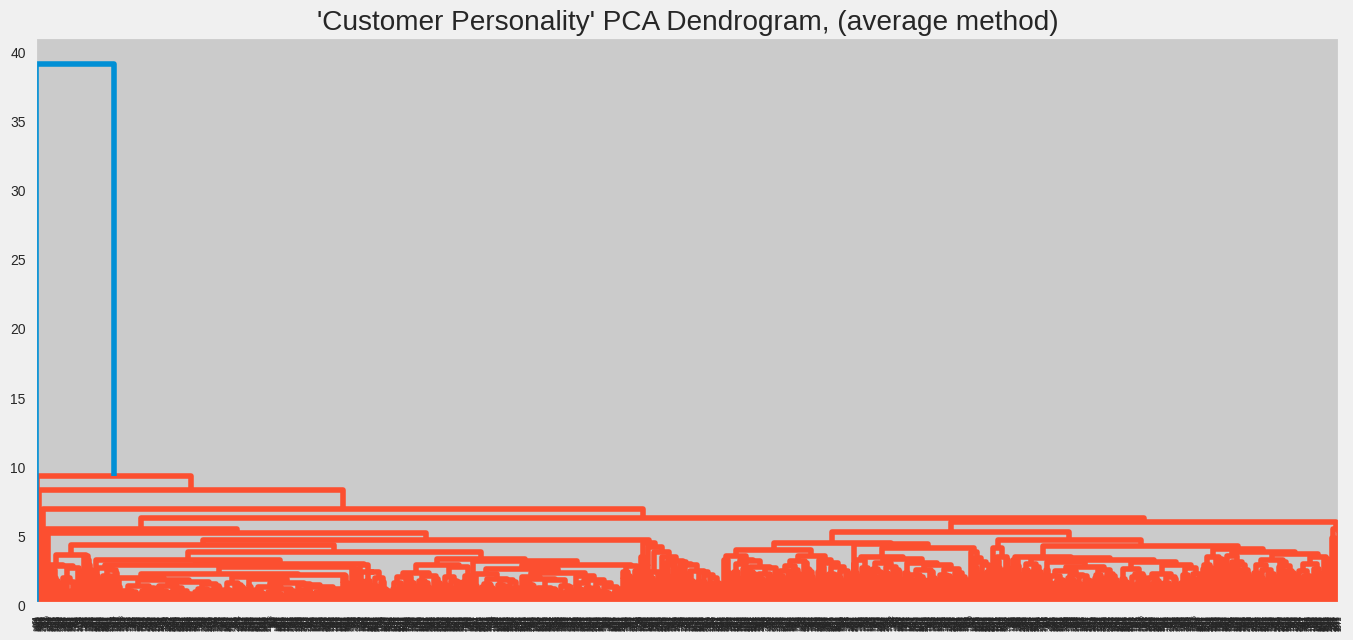

In [52]:
#Average linkage
plt.figure(figsize=(15, 7))
plt.title("'Customer Personality' PCA Dendrogram, (average method)")

clusters = shc.linkage(df_PCA,
            method='average',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

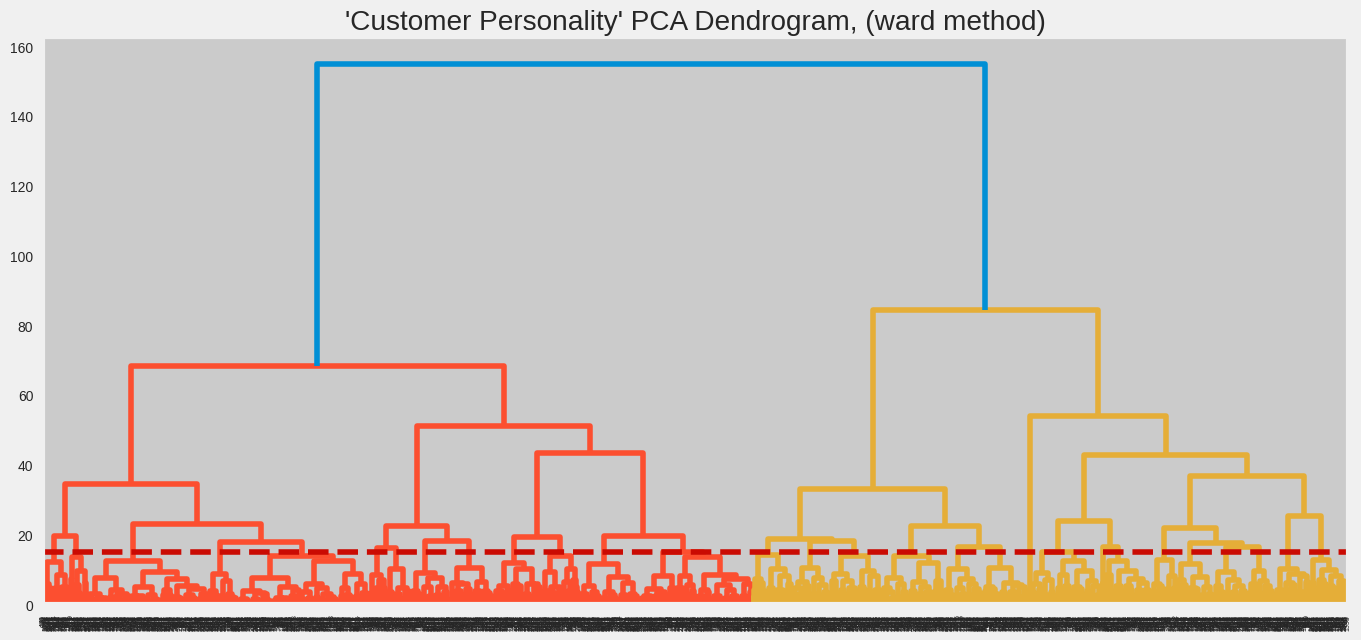

In [53]:
#Ward linkage
plt.figure(figsize=(15, 7))
plt.title("'Customer Personality' PCA Dendrogram, (ward method)")

clusters = shc.linkage(df_PCA,
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.axhline(y = 15, color = 'r', linestyle = '--')
plt.show()

Podemos apreciar por los resultados de los dendogramas que el único metodo que logró diferenciar dos grupos de clusters es el método "ward"; por lo tanto, será este método el que le asignaremos al cluster jerárquico para compararlo con el k-means. Es importante destacar que en el "Elbow Method" realizado anteriormente sobre k-means no quedaba del todo claro si era conveniente separar en 2 o 3 grupos, por lo cual, el cluster jerárquico nos puede brindar nueva y valiosa información.

In [54]:
clustering_model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
clustering_model.fit(df_PCA)

print(f'labels: {clustering_model.labels_}')

labels: [0 1 0 ... 0 0 1]


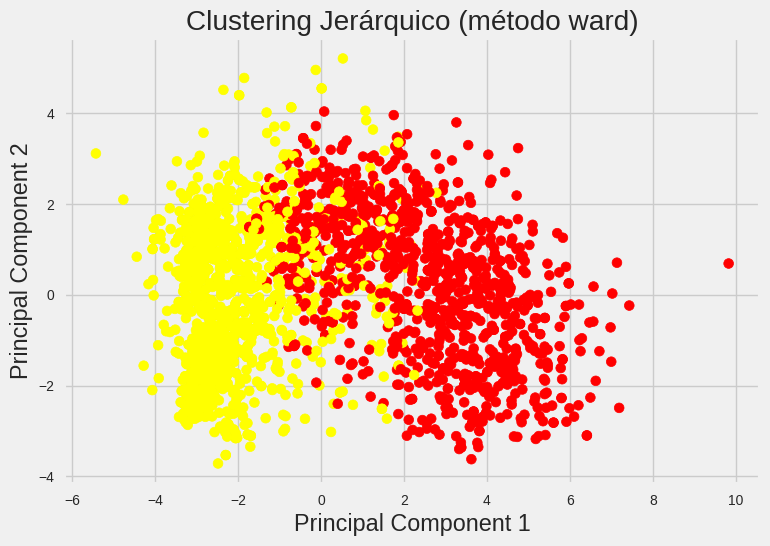

In [55]:
plt.scatter(df_PCA['PC1'], df_PCA['PC2'], c = clustering_model.labels_, cmap='autumn')
plt.title('Clustering Jerárquico (método ward)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Validación interna

### Vamos a generar un tercer cluster con k-means que contendra 2 grupos en vez de 3:

In [56]:
#guardamos las etiquetas de los clusterings anteriores:
k_means3_labels = kmeans.labels_

hierarchical_clus_labels = clustering_model.labels_

In [57]:
kmeans = KMeans(
    init="random",
    n_clusters=2, # asignamos 2 grupos
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(df_PCA)

KMeans(init='random', n_clusters=2, n_init=10, random_state=42)

In [58]:
#guardamos los resultados:
k_means2_labels = kmeans.labels_

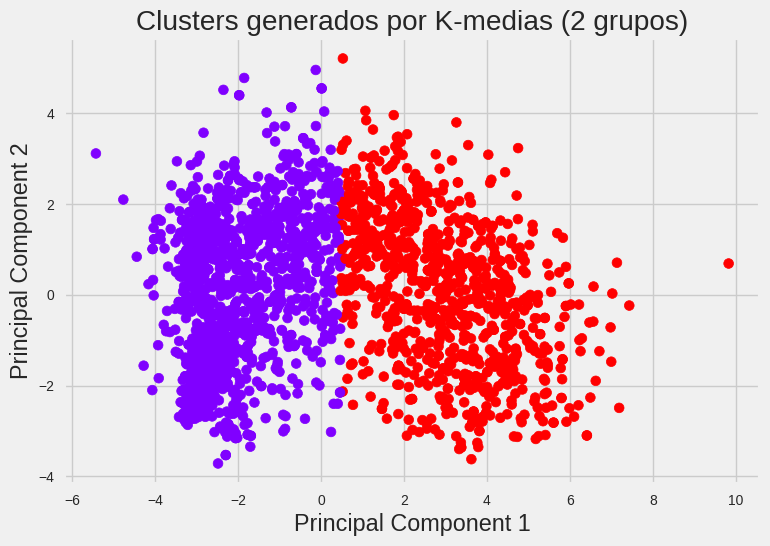

In [59]:
plt.scatter(df_PCA['PC1'], df_PCA['PC2'], c = kmeans.labels_, cmap='rainbow')
plt.title('Clusters generados por K-medias (2 grupos)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Si lo comparamos con el resultado del cluster jerárquico notamos que en este caso la división de los grupos es mucho más clara y no hay superposición. Esto no es necesariamente mejor ni peor ya que debemos recordar que estamos realizando una visualización (bidimensional) y que es por lo tanto una mera aproximación.

### Davies-Bouldin Score

La puntuación en el "Davies-Bouldin Score" se define como la medida de similitud promedio de cada grupo con su grupo más similar, donde la similitud es la relación entre las distancias dentro del grupo y las distancias entre grupos. Por lo tanto, los grupos que están más alejados y menos dispersos darán como resultado una puntuación mejor.

La puntuación mínima es cero, y valores más bajos indican una agrupación mejor.
(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)

In [60]:
#K-medias de 3 clusters
davies_bouldin_score(df_PCA, k_means3_labels)

1.3743289469625684

In [61]:
#K-medias de 2 clusters
davies_bouldin_score(df_PCA, k_means2_labels)

1.18118231573619

In [62]:
#Clustering jerárquico- 2 grupos:
davies_bouldin_score(df_PCA, hierarchical_clus_labels)

1.3039462964426562

El mejor resultado lo da el K-medias de 2 grupos.

### Silhoutte Score

In [63]:
#K-medias de 3 clusters
silhouette_score(df_PCA, k_means3_labels)

0.28201703223327435

In [64]:
#K-medias de 2 clusters
silhouette_score(df_PCA, k_means2_labels)

0.357537658314499

In [65]:
#Clustering Jerarquico
silhouette_score(df_PCA, hierarchical_clus_labels)

0.309568662737087

Al revés de la prueba anterior, en el test de Siluette un número cercano a 1 implica que los clústeres son muy cohesivos y están bien separados entre sí. Los valores negativos generalmente sugieren que un punto de datos ha sido asignado al clúster incorrecto. Los valores rondando el 0 sugieren que los clústeres se superponen, lo que podría indicar que el agrupamiento no es muy claro o que algunos puntos de datos pueden pertenecer a múltiples clústeres (datos tomados de https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

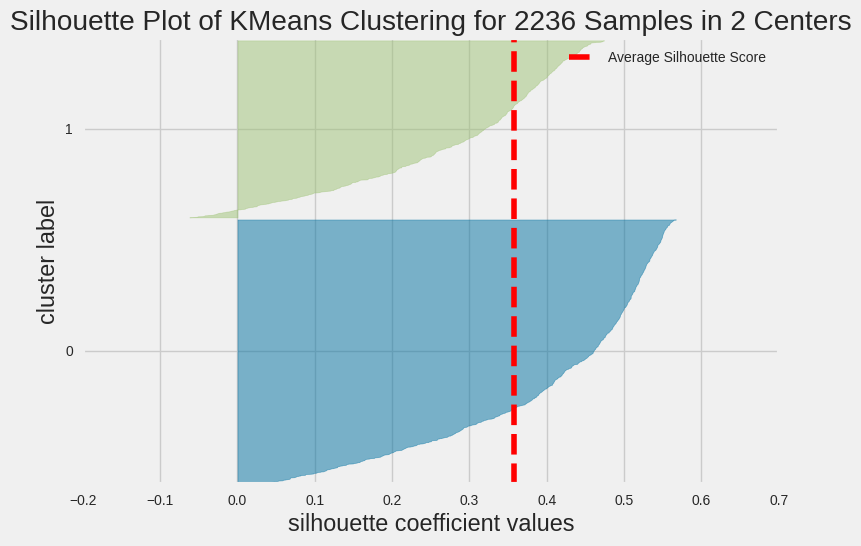

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2236 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, n_init=10, random_state=42))

In [66]:
#Kmeans con k=2 (el que elegimos)
silhouette_visualizer(KMeans(2, n_init=10, random_state=42), df_PCA, colors='yellowbrick')

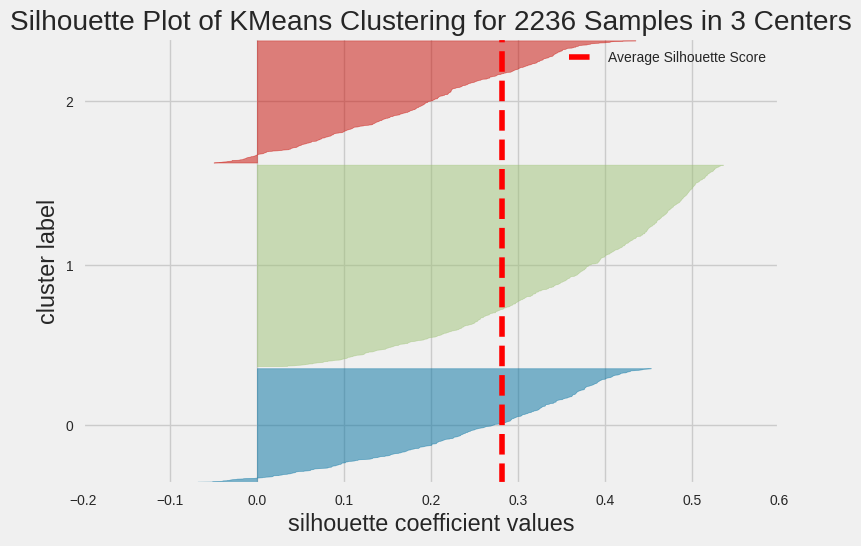

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2236 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [67]:
#Kmeans con k=3
silhouette_visualizer(KMeans(3, n_init=10, random_state=42), df_PCA, colors='yellowbrick')

En la gráfica de silhouette para el k_means 2 encontramos menos puntos mal clasificados, lo cual nos confirma los resultados de los test anteriores.

## Validación externa

Indice de Rand Ajustado (ARI)

Podemos comparar las etiquetas de nuestras variables originales con la agrupación que
obtuvimos con el método de clustering.

El valor del ARI varía de -1 a 1, donde:

1 significa un acuerdo perfecto,

0 significa un acuerdo esperado por azar

y valores negativos indican un acuerdo peor que el esperado por azar.

Un valor positivo de ARI indica que el acuerdo entre los agrupamientos es mejor de lo esperado por azar.

Compararemos nuestro clusters con diversas variables del dataset aver si encontramos alguna correspondencia:

In [68]:
def k_means2_ARI(column):
  labels_true = df[column]
  labels_pred = k_means2_labels
  return adjusted_rand_score(labels_true, labels_pred)

In [69]:
resultados = []

for col in df_cat_col:
    ari_value = k_means2_ARI(col)
    resultados.append((col, ari_value))

#ordenamos los resultados de forma descendente
resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)

for col, ari in resultados_ordenados:
    print(f'columna: {col}, ARI: {ari}')


columna: AcceptedCmp5, ARI: 0.08973985919198814
columna: AcceptedCmp1, ARI: 0.06399989808144528
columna: Response, ARI: 0.04994009199494477
columna: AcceptedCmp4, ARI: 0.03819623242335881
columna: AcceptedCmp2, ARI: 0.011164638968742294
columna: AcceptedCmp3, ARI: 0.005182857462430599
columna: Complain, ARI: -0.0007616477999765967


In [70]:
#comparemos con la variable "kidHome"
adjusted_rand_score(df['Kidhome'], k_means2_labels)

0.27721075141912954

Hemos realizado primero un ciclo for por todas las variables dicotómicas y luego sobre algunas variables categóricas que tengan pocos valores únicos. El objetivo es encontrar un valor del índice de Rand que nos sugiriera alguna aproximación entre los clusters realizados y los agrupamientos de algunas variables originales.

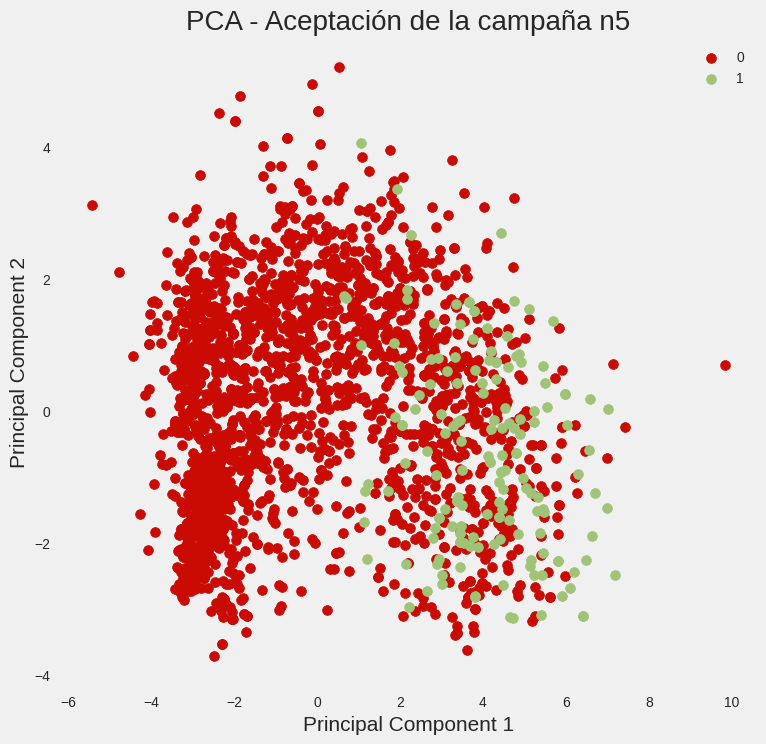

In [71]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Aceptación de la campaña n5', fontsize = 20)
targets = [0, 1]
colors = [ 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['AcceptedCmp5'] == target
    indicesToKeep = indicesToKeep.reset_index(drop=True)
    ax.scatter(df_PCA.loc[indicesToKeep, 'PC1']
               , df_PCA.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)

ax.grid()

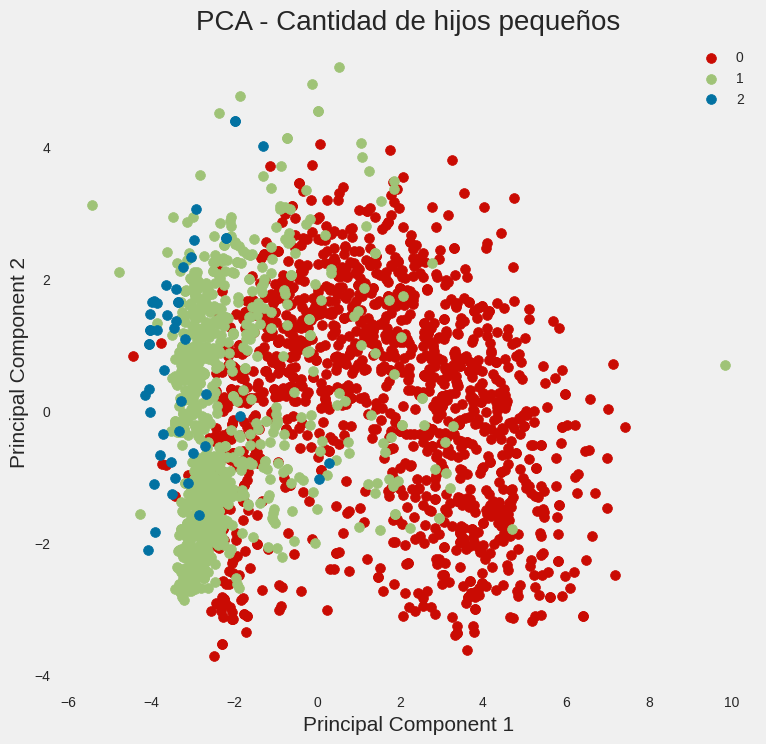

In [72]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Cantidad de hijos pequeños', fontsize = 20)
targets = [0, 1, 2]
colors = [ 'r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['Kidhome'] == target
    indicesToKeep = indicesToKeep.reset_index(drop=True)
    ax.scatter(df_PCA.loc[indicesToKeep, 'PC1']
               , df_PCA.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)

ax.grid()

Podemos apreciar que no hay una variable que explique por sí sola, con contundencia, los clusters realizados sobre los componentes principales.

## Último punto:

Grafiquemos el biplot:

In [73]:
scalePC1 = 1.0/(df_PCA['PC1'].max() - df_PCA['PC1'].min())
scalePC2 = 1.0/(df_PCA['PC2'].max() - df_PCA['PC2'].min())
l = pca.components_
features = df_scaled.columns

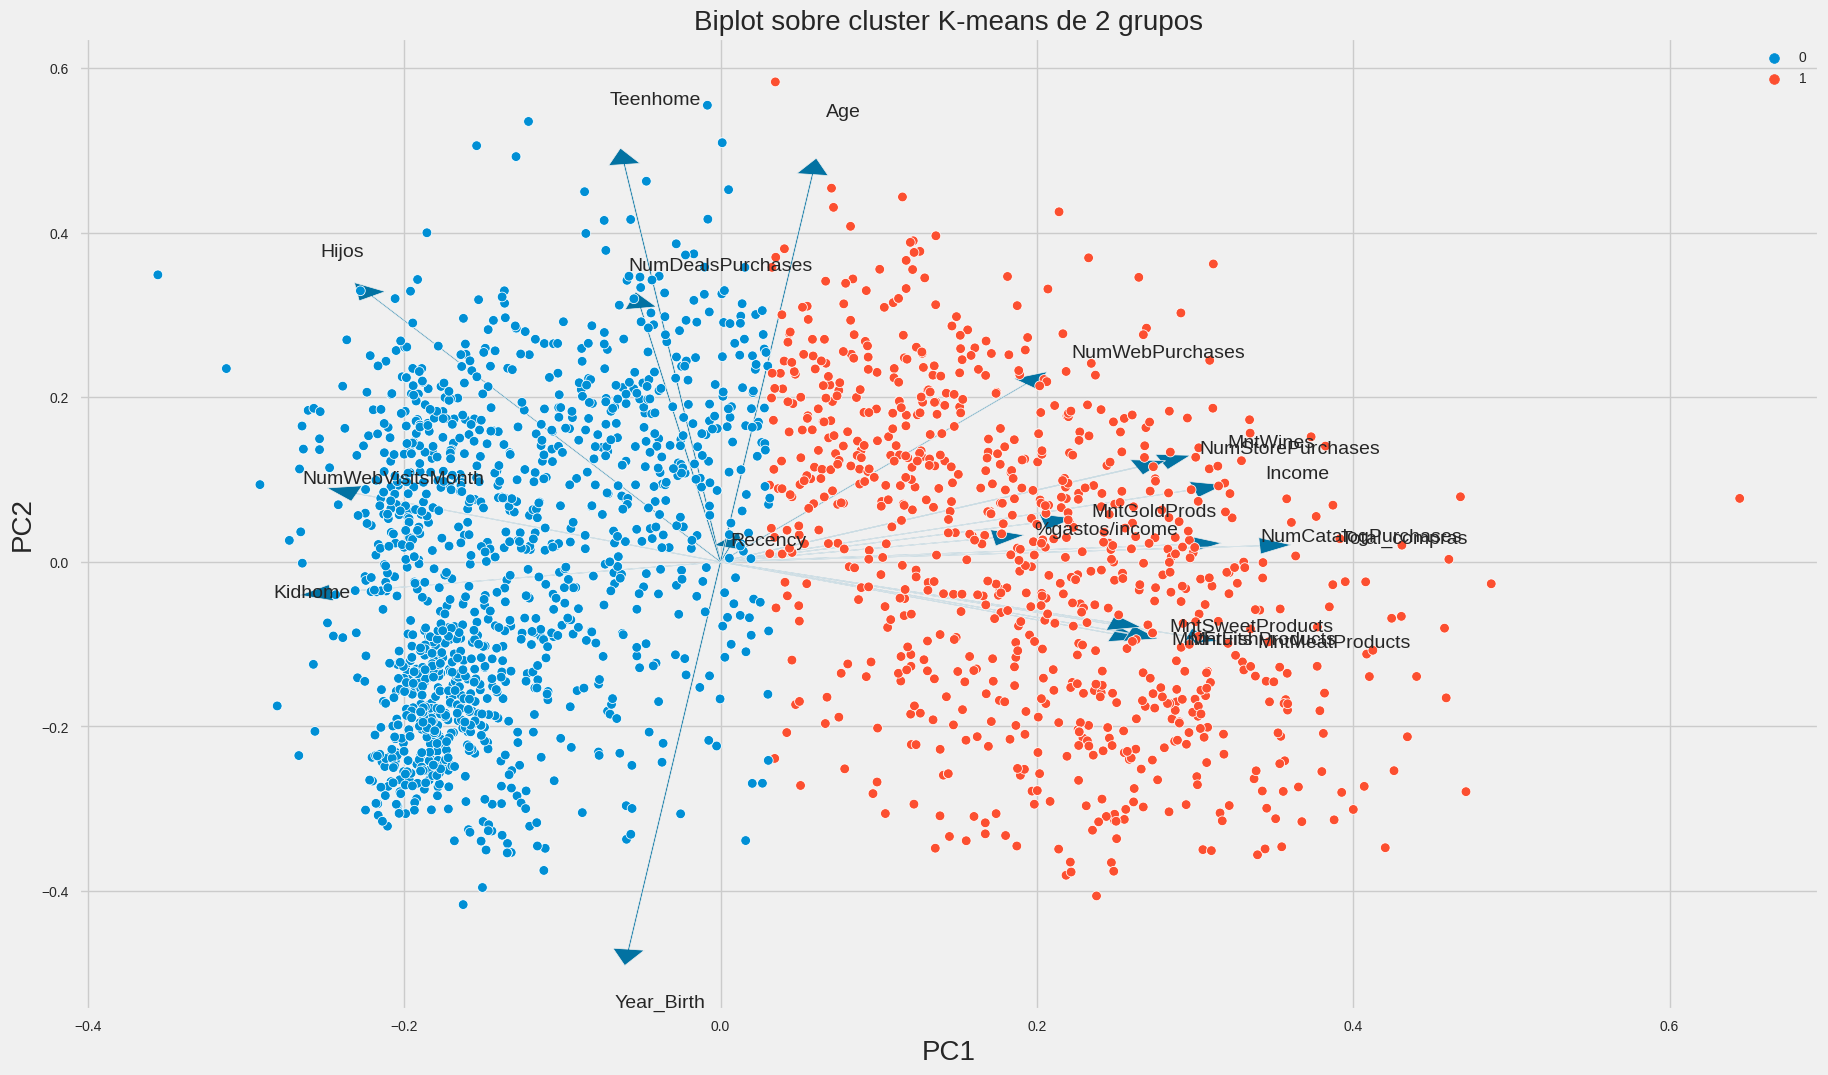

In [74]:
plt.figure(figsize=(20,12))

for i, features in enumerate(features):
    plt.arrow(0, 0, l[0, i],
             l[1, i],
              head_width=0.02,
             head_length=0.02)
    plt.text(l[0, i] * 1.15,
            l[1, i] * 1.15,
            features, fontsize=14)

sns.scatterplot(x=df_PCA['PC1'] * scalePC1,
                y=df_PCA['PC2'] * scalePC2,
                hue= kmeans.labels_)

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title('Biplot sobre cluster K-means de 2 grupos', fontsize=20)
plt.show()

Observamos que las variables relacionadas con ingresos o consumos tienen predominantemente una dirección paralela y positiva al eje x, es decir, al pc1, lo que nos recuerda la predominancia de esas variables en ese componente. La cercanía de estas variables entre sí denota una correlación positiva. El ángulo de 90 grados entre estas variables y las variables referidas a la edad de los clientes nos marca que no existe una correlación clara y se identifica -como vimos más arriba en los loadings- con el pc2. El pc3 tenía como variable más relevante el número de compras en oferta realizadas y esta se encuentra en el biplot en un ángulo pequeño con la variable edad por lo que podemos inferir que las variables más relevantes del pc3 y el pc2 se hayan más correlacionadas que con el pc1. La variable "Recency" (que componía el pc4) se haya en el punto(0,0) del biplot, lo que significa que esa variable no tiene una contribución significativa a ninguno de los dos componentes principales representados. En dirección negativa y paralela al eje x encontramos las variables de hijos y visitas a la página web.

Por lo tanto, nuestro cluster parece identificar a las variables del pc1 como más relevantes y el agrupamiento parece ser sensible a esto.
Podemos colegir que los clusters generados agrupan a los clientes principalmente en base a las variables relacionadas con ingresos y gastos y al mismo tiempo por sus visitas a la página web y su composición familiar.

El cluster 0 parece estar compuesto por clientes que visitan usualmente la página web y que tienen familias con niños, pero tienen ingresos y gastos relativamente bajos. El cluster 1, al contrario, está formado por clientes con mayores ingresos y un mayor gasto en el supermercado.

In [75]:
df['k_means']= kmeans.labels_

In [80]:
k_means_stats = df.groupby('k_means')
k_means_stats['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
k_means,,,,,,,,
0,1335.0,39041.726325,15315.346143,1730.0,28543.5,38513.0,49125.0,162397.0
1,901.0,71098.180943,13288.701703,2447.0,63342.0,71128.0,79593.0,160803.0


El promedio de ingresos en el cluster 0 es 39.000 y en el 1 es 71.000

In [81]:
k_means_stats['Total_compras'].describe()

,count,mean,std,min,25%,50%,75%,max
k_means,,,,,,,,
0,1335.0,184.021723,196.641292,5.0,45.0,90.0,275.0,1178.0
1,901.0,1231.206437,432.208738,277.0,907.0,1169.0,1533.0,2525.0


El promedio de gastos totales en la tienda es para 184 para el cluster 0 y 1231 para el cluster 1. La mediana es de 90 y 1169 respectivamente.

In [84]:
k_means_stats['Kidhome'].describe()

,count,mean,std,min,25%,50%,75%,max
k_means,,,,,,,,
0,1335.0,0.703371,0.529869,0.0,0.0,1.0,1.0,2.0
1,901.0,0.059933,0.237495,0.0,0.0,0.0,0.0,1.0


Como podemos apreciar, el grupo 0 se caracteriza por tener niños con un promedio cercano a 1, mientras que el promedio del grupo 1 es casi 0 -además de llegar al percentil 75 en 0-.

In [86]:
k_means_stats['NumWebVisitsMonth'].describe()

,count,mean,std,min,25%,50%,75%,max
k_means,,,,,,,,
0,1335.0,6.406742,1.951077,0.0,5.0,7.0,8.0,20.0
1,901.0,3.706992,2.151136,0.0,2.0,3.0,5.0,9.0


Vemos también en esta variable las diferencias notorias: en el cluster 0 el promedio de visitar mensuales a la página web es mayor a 6, mientras que en el grupo 1 es casi la mitad.

Interrogemos ahora alguna variable que en el biplot figuraba en ángulo de 90 grados en relación al eje de PC1:

In [87]:
k_means_stats['NumDealsPurchases'].describe()

,count,mean,std,min,25%,50%,75%,max
k_means,,,,,,,,
0,1335.0,2.560300,1.967673,0.0,1.0,2.0,3.0,15.0
1,901.0,1.978912,1.827141,0.0,1.0,1.0,3.0,15.0


Como vemos, esta variable no presenta diferencias contundentes entre ambos grupos -esto se puede apreciar sensiblemente en los percentiles-.